In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from random import sample
# from networkx import nx
# %matplotlib inline


In [2]:
# set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [3]:
# recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev
tau_s = 5 * ms              # synaptic time constant

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N_network = 1000                     # number of neurons

# simulation params
sim_time_ms = 1000 * 750                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

######################
#                    #
#   init the model   #
#                    #
######################
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
'''

G = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost
                        w = clip(w + Apre, 0, wMax)''')
           
# connect synapses
synapses.connect(condition='i!=j', p=p)
# erg = nx.erdos_renyi_graph(N_network, p, directed=True)#use erdos renyi random graph to determine synapse connections
num_synapses = len(synapses)
# for i in range(0, erg.number_of_nodes()):
#     nbs = [n for n in erg.neighbors(i)]
#     synapses.connect(i=[i], j=nbs) #connect neuron i to appropriate neighbors indicated in the erdos renyi graph
#     num_synapses += len(nbs)
#for i in range(N_network):
#    for j in range(N_network):
#        if i != j:
#            if np.random.rand() < p:
#                synapses.connect(i=i, j=j)
#                num_synapses += 1

# get connection density (for use in STDP params)
p0 = p #compute_p0(G, synapses)
# print(p0)

######################
#                    #
#    stdp params     #
#                    #
######################
# (replicated from matlab code)
#wMax = 5 * uamp * cm**-2               # max syn weight
#tauPre = 15 * ms                       # synaptic time constant
#tauPost = 2 * tauPre                   # synaptic time constant
#dApost = -wMax / 5 / N_network         # f neg (f post)
#dApre = -dApost * tauPost / tauPre     # f pos (f pre)

# (replicated from paper)
wMax = 5 * uamp * cm**-2               # max syn weight
tauPre = 5 * ms                        # synaptic time constant
tauPost = 5 * ms                       # synaptic time constant
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax / (N_network * p0)
dApre *= wMax / (N_network * p0)

# assign synaptic weights
w0 = wMax / N_network / p0 / 10
synapses.w = w0

# monitors
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=range(num_synapses), dt=monitor_dt_ms * ms)

# collect rate data of a subset of neurons:
#monitored_subset_size=100
#monitored_subset_size = min(monitored_subset_size, (N_network))
#idx_monitored_neurons = sample(range(N_network), monitored_subset_size)
#rate_monitor = PopulationRateMonitor(G)

# initial voltage values
for i in range(0, N_network):
    G[i].v = (np.random.normal(0, 1)*(vTh-vR)) #initial membrane potential for each neuron in neuron group

######################
#                    #
#   run simulation   #
#                    #
######################
run(sim_time_ms * ms, report='text')

Starting simulation at t=0. s for a duration of 0.75 ks
7.8744 s (1%) simulated in 10s, estimated 15m 42s remaining.
15.53 s (2%) simulated in 20s, estimated 15m 46s remaining.
22.8024 s (3%) simulated in 30s, estimated 15m 57s remaining.
29.7451 s (3%) simulated in 40s, estimated 16m 9s remaining.
37.5253 s (5%) simulated in 50s, estimated 15m 49s remaining.
42.492 s (5%) simulated in 1m 0s, estimated 16m 39s remaining.
49.3558 s (6%) simulated in 1m 10s, estimated 16m 34s remaining.
56.4682 s (7%) simulated in 1m 20s, estimated 16m 23s remaining.
62.6513 s (8%) simulated in 1m 30s, estimated 16m 27s remaining.
69.3856 s (9%) simulated in 1m 40s, estimated 16m 21s remaining.
76.6303 s (10%) simulated in 1m 50s, estimated 16m 7s remaining.
83.0306 s (11%) simulated in 2m 0s, estimated 16m 4s remaining.
90.4223 s (12%) simulated in 2m 10s, estimated 15m 48s remaining.
98.2545 s (13%) simulated in 2m 20s, estimated 15m 29s remaining.
106.0835 s (14%) simulated in 2m 30s, estimated 15m 11

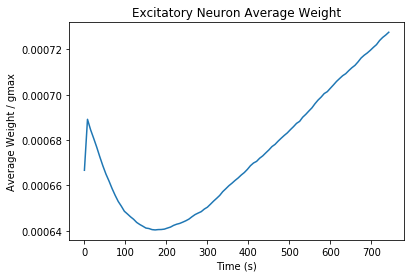

In [ ]:
# more plots
plot_avg_syn_weight(w_mon, wMax)

# figure 7
plot_motif_dynamics(w_mon, synapses, N_network, use_p0=False, save_fig=True)

In [ ]:
#plot_network_activity(rate_monitor, sp_mon_exc, w_mon, idx_monitored_neurons, t_min=400*1000*ms, t_max=700*1000*ms)